In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

dev = qml.device("default.qubit", wires=4)

def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

    
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [6]:
np.random.seed(1)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("df1.csv", encoding='latin1')
df["skupina"] = df["skupina"].replace({"otevrena": 1, "laparoskopicka": 0})


# Select the specified variables
#selected_vars = ["vek", "BMI", "pohlavi", "stadium", "cas.preziti", "zije"]
selected_vars = ["vek",  "pohlavi" , "stadium", "cas.preziti"]
# Extract only the selected variables and the target variable
df_selected = df[selected_vars + ["skupina"]]

df_selected["pohlavi"] = df_selected["pohlavi"].replace({"Zena": 0, "Muz": 1})
# Drop rows with missing values in the selected variables
df_selected = df_selected.dropna()

df_selected = df_selected.sample(n=100)

# Separate features (X) and target variable (y)
#X = df_selected.drop("skupina", axis=1)
X = df_selected.to_numpy()
Y = df_selected.to_numpy()[:,4]
Y[Y == 0] = -1
# Load the data from the file into a NumPy array
#data = np.loadtxt(file_path)
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

C:\Users\petre\AppData\Local\Temp\ipykernel_6504\1568332836.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["pohlavi"] = df_selected["pohlavi"].replace({"Zena": 0, "Muz": 1})


In [7]:
np.random.seed(1)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

num_qubits = 4
num_layers = 2

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 13

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

ValueError: BasisState parameter must consist of 0 or 1 integers.

C:\Users\petre\AppData\Local\Temp\ipykernel_14536\4008324298.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


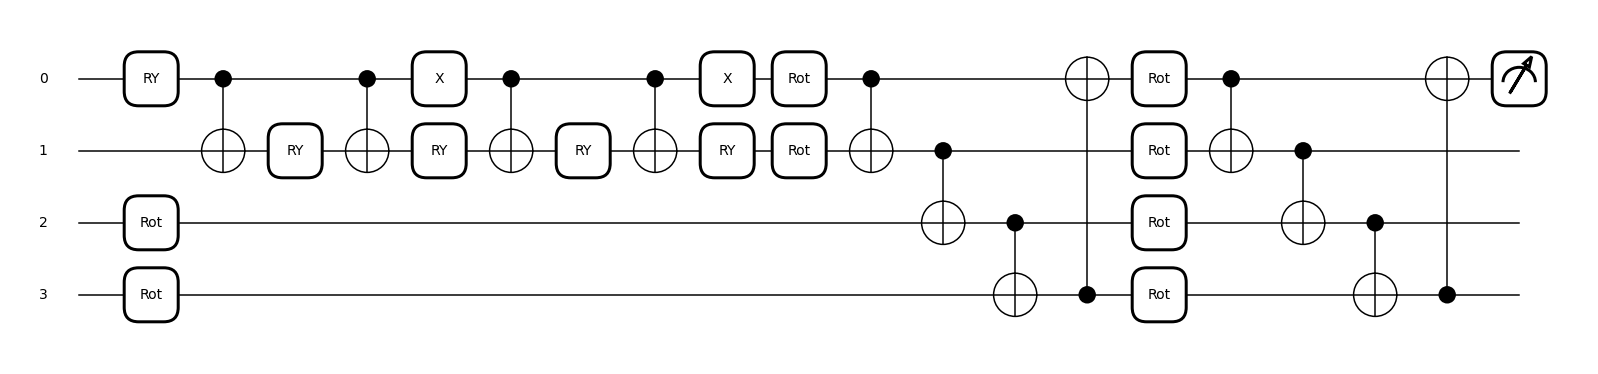

In [16]:
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)

fig, ax = qml.draw_mpl(circuit)(weights_init,feats_train)
fig.show()

In [17]:
np.random.seed(0)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

selected_vars = ["vek",  "pohlavi" , "stadium", "cas.preziti"]
df_selected = df[selected_vars + ["skupina"]]
df_selected["pohlavi"] = df_selected["pohlavi"].replace({"Zena": 0, "Muz": 1})

df_selected1 = df_selected.sample(n=100)
# Example: Impute missing values with the mean

# Extracting features (X) and target variable (Y)
X = df_selected1.iloc[:, :-1]
Y = df_selected1.iloc[:, -1]

X = X.fillna(X.mean())


# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating and training the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Making predictions on the test set
Y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

# Displaying results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_result)

Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.40      0.33      0.36         6

    accuracy                           0.65        20
   macro avg       0.57      0.56      0.56        20
weighted avg       0.63      0.65      0.64        20



C:\Users\petre\AppData\Local\Temp\ipykernel_14536\250950633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["pohlavi"] = df_selected["pohlavi"].replace({"Zena": 0, "Muz": 1})


In [18]:
np.random.seed(1)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

df_selected = df[selected_vars + ["skupina"]]
df_selected["pohlavi"] = df_selected["pohlavi"].replace({"Zena": 0, "Muz": 1})
df_selected1 = df_selected.sample(n=100)

X = df_selected1.iloc[:, :-1]
Y = df_selected1.iloc[:, -1]
X = X.fillna(X.mean())
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating and training the gradient boosting classifier
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)

# Making predictions on the test set
Y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

# Displaying results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_result)

Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.89      0.67         9
           1       0.80      0.36      0.50        11

    accuracy                           0.60        20
   macro avg       0.67      0.63      0.58        20
weighted avg       0.68      0.60      0.58        20



C:\Users\petre\AppData\Local\Temp\ipykernel_14536\4135939313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["pohlavi"] = df_selected["pohlavi"].replace({"Zena": 0, "Muz": 1})


In [19]:
num_models = 10
sample_size = 100

# List to store accuracy scores
accuracy_scores = []

# Perform logistic regression on multiple samples
for _ in range(num_models):
    # Sample data
    sampled_data = df_selected.sample(sample_size, random_state=_)

    # Extract features (X) and target variable (Y)
    X_sampled = sampled_data.iloc[:, :-1]
    Y_sampled = sampled_data.iloc[:, -1]
    X_sampled = X_sampled.fillna(X_sampled.mean())

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_sampled, test_size=0.2, random_state=42)
    # Create and train the logistic regression model
    model = LogisticRegression()
    #model = GradientBoostingClassifier()
    model.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred = model.predict(X_test)

    # Calculate accuracy and append to the list
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracy_scores.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracy_scores) / num_models

# Display the results
print("Mean Accuracy:", mean_accuracy)

Mean Accuracy: 0.53
